# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [2]:
!pip install numpy matplotlib nltk datasets torch tqdm torchmetrics


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [4]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(imdb_dataset["train"][:1])

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

In [8]:
from sklearn.model_selection import train_test_split

texts = imdb_dataset["train"]['text']
labels = imdb_dataset["train"]['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)


print(train_texts[:1])
print(train_labels[:1])

['I have always been a huge James Bond fanatic! I have seen almost all of the films except for Die Another Day, and The World Is Not Enough. The graphic\'s for Everything Or Nothing are breathtaking! The voice talents......... WOW! I LOVE PIERCE BROSNAN! He is finally Bond in a video game! HE IS BOND! I enjoyed the past Bond games: Goldeneye, The World Is Not Enough, Agent Under Fire, and Nightfire. This one is definitely the best! Finally, Mr. Brosnan, (may I call him Mr. Brosnan as a sign of respect? Yes I can!) He was phenomenally exciting to hear in a video game....... AT LONG LAST! DUH! I\'ve seen him perform with Robin Williams, and let me tell you, they make a great team. Pierce Brosnan is funny, wickedly handsome ( I mean to say wickedly in a good way,) and just one of those actor\'s who you would want to walk up to and wrap your arms around and hug, saying: "Pierce Brosnan, thank you for being James Bond," "If it wasn\'t for you, I wouldn\'t know who James Bond is." He\'s a gr

In [9]:
train_dataset = [{"text": text, "label": label} for text, label in zip(train_texts, train_labels)]
val_dataset = [{"text": text, "label": label} for text, label in zip(val_texts, val_labels)]



print(train_dataset[:1])
print(val_dataset[:1])


test_texts = imdb_dataset["test"]['text']
test_labels = imdb_dataset["test"]['label']

test_dataset = [{"text": text, "label": label} for text, label in zip(test_texts, test_labels)]

print(test_dataset[:1])

[{'text': 'I have always been a huge James Bond fanatic! I have seen almost all of the films except for Die Another Day, and The World Is Not Enough. The graphic\'s for Everything Or Nothing are breathtaking! The voice talents......... WOW! I LOVE PIERCE BROSNAN! He is finally Bond in a video game! HE IS BOND! I enjoyed the past Bond games: Goldeneye, The World Is Not Enough, Agent Under Fire, and Nightfire. This one is definitely the best! Finally, Mr. Brosnan, (may I call him Mr. Brosnan as a sign of respect? Yes I can!) He was phenomenally exciting to hear in a video game....... AT LONG LAST! DUH! I\'ve seen him perform with Robin Williams, and let me tell you, they make a great team. Pierce Brosnan is funny, wickedly handsome ( I mean to say wickedly in a good way,) and just one of those actor\'s who you would want to walk up to and wrap your arms around and hug, saying: "Pierce Brosnan, thank you for being James Bond," "If it wasn\'t for you, I wouldn\'t know who James Bond is." H

In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')

def clean(text, tokenizer, replace_with_num=False):

    if replace_with_num:
        cleaned_text = re.sub(r'\d+', 'num', text)
    else:
        cleaned_text = re.sub(r'\d+', '', text)

    cleaned_text = cleaned_text.lower()

    tokens = tokenizer.tokenize(cleaned_text)

    return tokens

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

nltk.download('punkt')
nltk.download('wordnet')

def cleanWithLemmaAndStem(text, tokenizer, lemmatizer, stemmer, replace_with_num=False):

    if replace_with_num:
        cleaned_text = re.sub(r'\d+', 'num', text)
    else:
        cleaned_text = re.sub(r'\d+', '', text)

    cleaned_text = cleaned_text.lower()

    tokens = tokenizer.tokenize(cleaned_text)

  

    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
clean("This IS 1 example sentence", RegexpTokenizer(r'\w+'))

['this', 'is', 'example', 'sentence']

In [19]:



import re
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm


def get_word2idx(corpus, minlen , maxlen, replace_with_num=False):
    word2idx = {}
    idx = 1 
    tokenizer = RegexpTokenizer(r'\w+')

    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        tokens = clean(sentence, tokenizer, replace_with_num=False)

        if len(tokens) < minlen or len(tokens) > maxlen:
            continue

        for word in tokens:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1

    return idx, word2idx



corpus = texts + test_texts
minlen, maxlen = 100, 500  # Example word count range
idx, word2idx = get_word2idx(corpus, minlen, maxlen)
word2idx["<pad>"] = 0;
print("Final Index:", idx)




Creating word2idx: 100%|██████████| 50000/50000 [00:07<00:00, 6484.10it/s]

Final Index: 86796


In [20]:



import re
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm


def get_word2idx2(corpus, minlen , maxlen, replace_with_num=False):
    word2idx = {}
    idx = 1 
    tokenizer = RegexpTokenizer(r'\w+')

    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        tokens = cleanWithLemmaAndStem(sentence, tokenizer, lemmatizer, stemmer, replace_with_num=replace_with_num)

        if len(tokens) < minlen or len(tokens) > maxlen:
            continue

        for word in tokens:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1

    return idx, word2idx



corpus = texts + test_texts
minlen, maxlen = 100, 500 
idx2, word2idx2 = get_word2idx2(corpus, minlen, maxlen)
word2idx2["<pad>"] = 0;
print("Final Index:", idx2)




Creating word2idx: 100%|██████████| 50000/50000 [05:23<00:00, 154.41it/s]

Final Index: 60394


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

class IMDBDataset(Dataset):
    def __init__(self, dataset, vocab, minlen=100, maxlen=500):
        self.count = 0 
        count1 = 0
        input_data = []
        target_data = []

        for entry in tqdm(dataset, total=len(dataset), desc="Processing data"):
            text = entry['text']  
            label = entry['label'] 

            tokenizer = RegexpTokenizer(r'\w+')
            text = clean(text, tokenizer, 0)

            if len(text) < minlen or len(text) > maxlen:
              continue


            
            tokenized_text = []
            for word in text:
                if word in vocab:
                    token = vocab[word]
                    tokenized_text.append(token)
                else:
                    count1 = count1 + 1
                    

            if minlen <= len(tokenized_text) <= maxlen:
                input_data.append(torch.tensor(tokenized_text, dtype=torch.long))
                target_data.append(label)
                self.count += 1

        self.final_count1 = count1
        self.inputs = pad_sequence(input_data, batch_first=True, padding_value=vocab['<pad>'])
        self.targets = torch.tensor(target_data, dtype=torch.long)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]

    
    
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

class IMDBDataset2(Dataset):
    def __init__(self, dataset, vocab, minlen=100, maxlen=500):
        self.count = 0 
        count1 = 0
        input_data = []
        target_data = []

        
        for entry in tqdm(dataset, total=len(dataset), desc="Processing data"):
            text = entry['text']  
            label = entry['label'] 

            tokenizer = RegexpTokenizer(r'\w+')
            text = cleanWithLemmaAndStem(text, tokenizer, lemmatizer, stemmer, 0)

            if len(text) < minlen or len(text) > maxlen:
              continue


            tokenized_text = []
            for word in text:
                if word in vocab:
                    token = vocab[word]
                    tokenized_text.append(token)
                else:
                    count1 = count1 + 1
                   

            if minlen <= len(tokenized_text) <= maxlen:
                input_data.append(torch.tensor(tokenized_text, dtype=torch.long))
                target_data.append(label)
                self.count += 1

        self.final_count1 = count1
        self.inputs = pad_sequence(input_data, batch_first=True, padding_value=vocab['<pad>'])
        self.targets = torch.tensor(target_data, dtype=torch.long)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]


In [22]:
train_ds = IMDBDataset(train_dataset, word2idx, minlen=100, maxlen=500)
print(train_ds.final_count1)

val_ds = IMDBDataset(val_dataset, word2idx, minlen=100, maxlen=500)
print(val_ds.final_count1)

test_ds = IMDBDataset(test_dataset, word2idx, minlen=100, maxlen=500)
print(test_ds.final_count1)


Processing data: 100%|██████████| 20000/20000 [00:04<00:00, 4108.23it/s]


0


Processing data: 100%|██████████| 5000/5000 [00:01<00:00, 4121.25it/s]


0


Processing data: 100%|██████████| 25000/25000 [00:06<00:00, 4018.51it/s]


0


In [23]:


train_ds2 = IMDBDataset2(train_dataset, word2idx2, minlen=100, maxlen=500)
print(train_ds2.final_count1)

val_ds2 = IMDBDataset2(val_dataset, word2idx2, minlen=100, maxlen=500)
print(val_ds2.final_count1)

test_ds2 = IMDBDataset2(test_dataset, word2idx2, minlen=100, maxlen=500)
print(test_ds2.final_count1)

Processing data: 100%|██████████| 20000/20000 [02:13<00:00, 150.35it/s]


0


Processing data: 100%|██████████| 5000/5000 [00:33<00:00, 149.46it/s]


0


Processing data: 100%|██████████| 25000/25000 [02:42<00:00, 153.97it/s]


0


In [24]:
len(train_ds), len(val_ds), len(test_ds)

(16046, 4002, 20048)

In [25]:
len(train_ds2), len(val_ds2), len(test_ds2)

(16046, 4002, 20048)

In [26]:
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)


params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader2 = DataLoader(train_ds2, **params)
val_dataloader2 = DataLoader(val_ds2, **params)
test_dataloader2 = DataLoader(test_ds2, **params)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim) 
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True) 
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, X):
        embedded = self.embedding(X) 
        output, hidden = self.rnn(embedded)  

      
        logits = self.fc(hidden[-1])  

        return logits



In [28]:
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

vocab_size = idx 
vocab_size2 = idx2 
num_classes = 2  

model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)
model2 = RNNModel(vocab_size2, hidden_size, embedding_dim, num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

print(model)
print(model2)

RNNModel(
  (embedding): Embedding(86796, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
RNNModel(
  (embedding): Embedding(60394, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [29]:
import torch
from torch import nn
from tqdm import tqdm


loss_function = nn.CrossEntropyLoss()

best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []

def train_model(train_dataloader,val_dataloader,model):
    global best_val_accuracy 

    for epoch in range(epochs):
        model.train() 
        epoch_train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/ Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            optimizer.zero_grad()  
            outputs = model(input_batch) 
            loss = loss_function(outputs, output_batch)  
            loss.backward()  
            optimizer.step()  

            epoch_train_loss += loss.item() * input_batch.size(0)

        epoch_train_loss = epoch_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

       
        model.eval()  
        epoch_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad(): 
            for input_batch, output_batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/ Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                outputs = model(input_batch)
                loss = loss_function(outputs, output_batch)
                epoch_val_loss += loss.item() * input_batch.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == output_batch).sum().item()

        epoch_val_loss = epoch_val_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_val_accuracy = correct_predictions / len(val_dataloader.dataset)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy

    return train_losses, val_losses, val_accuracies



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



RNNModel(
  (embedding): Embedding(86796, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [30]:
import torch
from torch import nn
from tqdm import tqdm


loss_function = nn.CrossEntropyLoss()

best_val_accuracy2 = 0.0
train_losses2 = []
val_losses2 = []
val_accuracies2 = []

def train_model2(train_dataloader2,val_dataloader2,model2):
    global best_val_accuracy2 

    for epoch in range(epochs):
        model2.train()  
        epoch_train_loss2 = 0.0
        for input_batch, output_batch in tqdm(train_dataloader2, desc=f"Epoch {epoch+1}/ Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            optimizer2.zero_grad() 
            outputs = model2(input_batch)
            loss = loss_function(outputs, output_batch)
            loss.backward() 
            optimizer2.step() 

            epoch_train_loss2 += loss.item() * input_batch.size(0)

        epoch_train_loss2 = epoch_train_loss2 / len(train_dataloader2.dataset)
        train_losses2.append(epoch_train_loss2)

       
        model2.eval()  
        epoch_val_loss2 = 0.0
        correct_predictions = 0
        with torch.no_grad():  
            for input_batch, output_batch in tqdm(val_dataloader2, desc=f"Epoch {epoch+1}/ Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                outputs = model2(input_batch)
                loss = loss_function(outputs, output_batch)
                epoch_val_loss2 += loss.item() * input_batch.size(0)

               
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == output_batch).sum().item()

       
        epoch_val_loss2 = epoch_val_loss2 / len(val_dataloader2.dataset)
        val_losses2.append(epoch_val_loss2)

        epoch_val_accuracy2 = correct_predictions / len(val_dataloader2.dataset)
        val_accuracies2.append(epoch_val_accuracy2)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss2:.4f}, Val Loss: {epoch_val_loss2:.4f}, Val Accuracy: {epoch_val_accuracy2:.4f}')

        if epoch_val_accuracy2 > best_val_accuracy2:
            best_val_accuracy2 = epoch_val_accuracy2
            

    return train_losses2, val_losses2, val_accuracies2



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)



RNNModel(
  (embedding): Embedding(60394, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [77]:
train_losses, val_losses, val_accuracy = train_model(train_dataloader,val_dataloader,model)

Epoch 1/ Validation: 100%|██████████| 126/126 [00:08<00:00, 15.64it/s]


Epoch 1: Train Loss: 0.7021, Val Loss: 0.7011, Val Accuracy: 0.5160


Epoch 2/ Validation: 100%|██████████| 126/126 [00:07<00:00, 16.07it/s]


Epoch 2: Train Loss: 0.7065, Val Loss: 0.7109, Val Accuracy: 0.5055


Epoch 3/ Validation: 100%|██████████| 126/126 [00:07<00:00, 15.80it/s]


Epoch 3: Train Loss: 0.7039, Val Loss: 0.6974, Val Accuracy: 0.5082


Epoch 4/ Validation: 100%|██████████| 126/126 [00:07<00:00, 15.97it/s]


Epoch 4: Train Loss: 0.7055, Val Loss: 0.7052, Val Accuracy: 0.5060


Epoch 5/ Validation: 100%|██████████| 126/126 [00:07<00:00, 16.26it/s]

Epoch 5: Train Loss: 0.7049, Val Loss: 0.6975, Val Accuracy: 0.4963


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [25]:
train_losses2, val_losses2, val_accuracy2 = train_model2(train_dataloader2,val_dataloader2,model2)

Epoch 1/ Validation: 100%|██████████| 126/126 [00:08<00:00, 14.89it/s]


Epoch 1: Train Loss: 0.7009, Val Loss: 0.6940, Val Accuracy: 0.4840


Epoch 2/ Validation: 100%|██████████| 126/126 [00:08<00:00, 14.74it/s]


Epoch 2: Train Loss: 0.6959, Val Loss: 0.6997, Val Accuracy: 0.5160


Epoch 3/ Validation: 100%|██████████| 126/126 [00:08<00:00, 15.59it/s]


Epoch 3: Train Loss: 0.6951, Val Loss: 0.6926, Val Accuracy: 0.5160


Epoch 4/ Validation: 100%|██████████| 126/126 [00:08<00:00, 15.75it/s]


Epoch 4: Train Loss: 0.7067, Val Loss: 0.6926, Val Accuracy: 0.5157


Epoch 5/ Validation: 100%|██████████| 126/126 [00:08<00:00, 14.20it/s]

Epoch 5: Train Loss: 0.7040, Val Loss: 0.6971, Val Accuracy: 0.4840


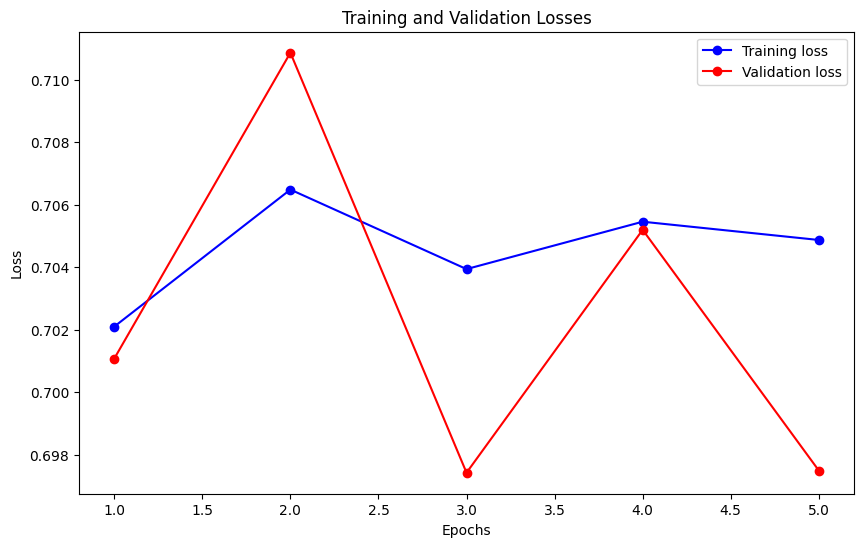

In [78]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


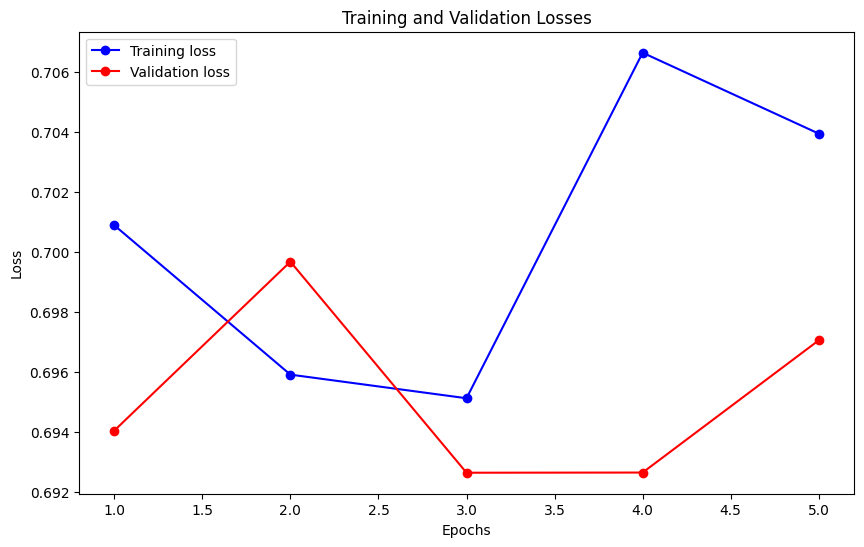

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses2) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses2, 'bo-', label='Training loss')
plt.plot(epochs, val_losses2, 'ro-', label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


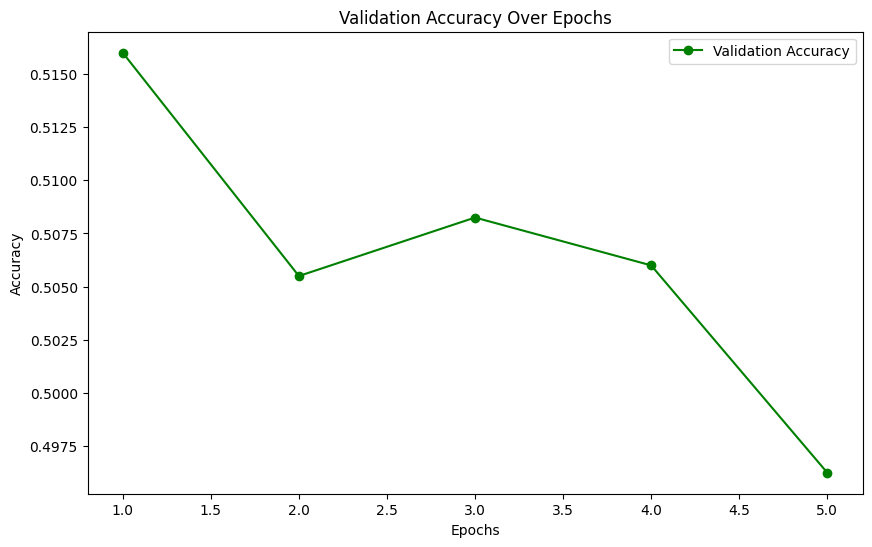

In [79]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


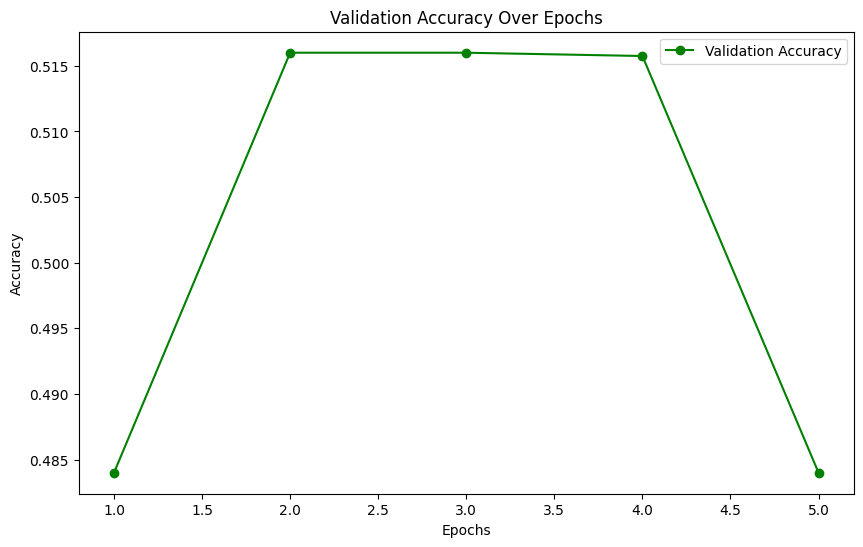

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracies2) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies2, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [80]:
import torch

model.eval() 
correct_predictions = 0
total_predictions = 0

with torch.no_grad(): 
    for input_batch, output_batch in test_dataloader:
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        
        outputs = model(input_batch)
        
        _, predicted = torch.max(outputs, 1) 
        correct_predictions += (predicted == output_batch).sum().item() 
        total_predictions += output_batch.size(0)  

test_accuracy = correct_predictions / total_predictions 
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.4984


In [28]:
import torch

model.eval() 
correct_predictions = 0
total_predictions = 0

with torch.no_grad(): 
    for input_batch, output_batch in test_dataloader2:
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        
        outputs = model(input_batch)
        
        _, predicted = torch.max(outputs, 1) 
        correct_predictions += (predicted == output_batch).sum().item()  
        total_predictions += output_batch.size(0) 

test_accuracy = correct_predictions / total_predictions 
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.5095


What changes do you observe in accuracy ? (stemming)

almost same accuracy

intuition: vanishing gradient and context loss may  still exist for , since sentences  are 100 -500 long, so stemming is not much of a help.



#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [70]:
import torch
from torch import nn
from tqdm import tqdm


loss_function = nn.CrossEntropyLoss()
epochs = 5
best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []

def train_model_general(train_dataloader,val_dataloader,model,optimizer):
    
    global best_val_accuracy 

    for epoch in range(epochs):
        model.train()  
        epoch_train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/ Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            optimizer.zero_grad() 
            outputs = model(input_batch) 
            loss = loss_function(outputs, output_batch) 
            loss.backward() 
            optimizer.step() 

            epoch_train_loss += loss.item() * input_batch.size(0)

        epoch_train_loss = epoch_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()  
        epoch_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/ Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                outputs = model(input_batch)
                loss = loss_function(outputs, output_batch)
                epoch_val_loss += loss.item() * input_batch.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == output_batch).sum().item()

        epoch_val_loss = epoch_val_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_val_accuracy= correct_predictions / len(val_dataloader.dataset)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy

    return train_losses, val_losses, val_accuracies






In [71]:
import torch
import torch.nn as nn

class LastOutputRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LastOutputRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
     
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        
        output, _ = self.rnn(embedded) 
        
        last_output = output[:, -1, :]  
        
        logits = self.fc(last_output) 
        
        return logits


model3 = LastOutputRNNModel(vocab_size2, hidden_size, embedding_dim, num_classes).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [72]:
best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []

train_losses3, val_losses3, val_accuracy3 = train_model_general(train_dataloader2,val_dataloader2,model3,optimizer3)

Epoch 1/ Validation: 100%|██████████| 126/126 [00:00<00:00, 195.75it/s]


Epoch 1: Train Loss: 0.7054, Val Loss: 0.7080, Val Accuracy: 0.5147


Epoch 2/ Validation: 100%|██████████| 126/126 [00:00<00:00, 190.97it/s]


Epoch 2: Train Loss: 0.7083, Val Loss: 0.7017, Val Accuracy: 0.5092


Epoch 3/ Validation: 100%|██████████| 126/126 [00:00<00:00, 196.43it/s]


Epoch 3: Train Loss: 0.7046, Val Loss: 0.6976, Val Accuracy: 0.5182


Epoch 4/ Validation: 100%|██████████| 126/126 [00:00<00:00, 187.98it/s]


Epoch 4: Train Loss: 0.7032, Val Loss: 0.7086, Val Accuracy: 0.5040


Epoch 5/ Validation: 100%|██████████| 126/126 [00:00<00:00, 197.59it/s]

Epoch 5: Train Loss: 0.7019, Val Loss: 0.7126, Val Accuracy: 0.5045


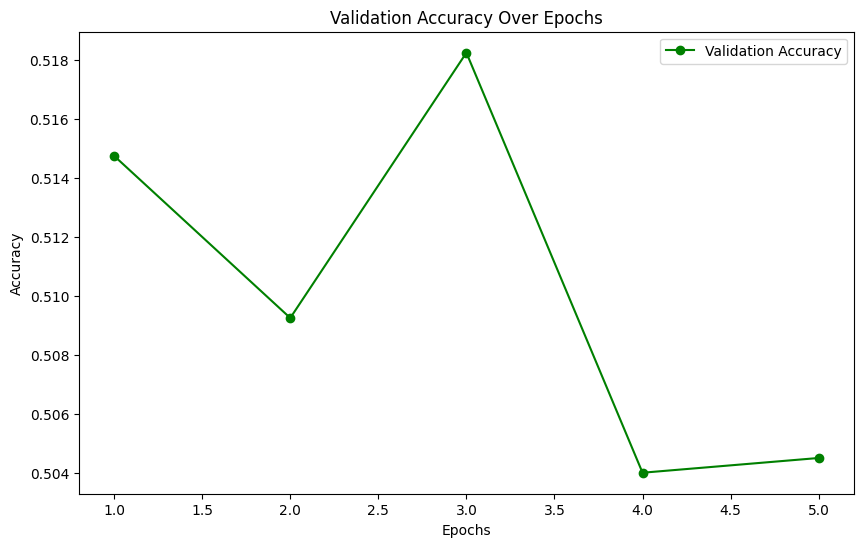

In [73]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy3) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy3, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


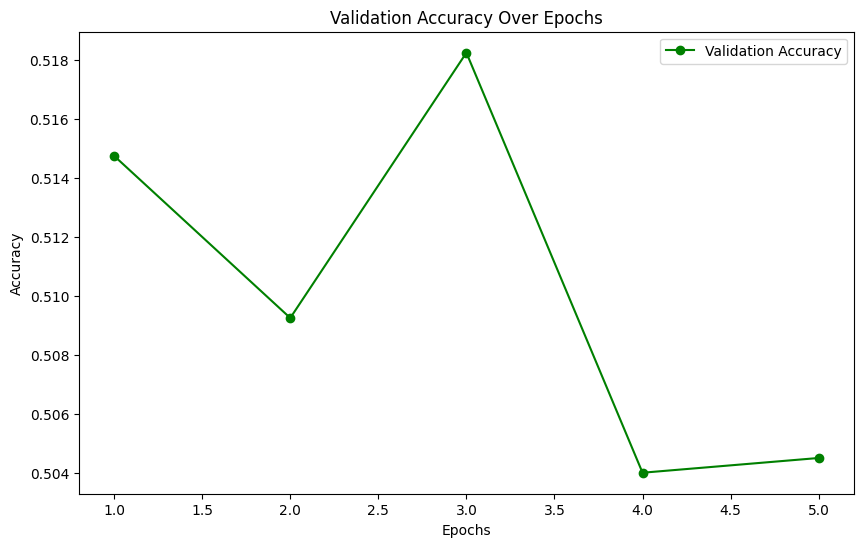

In [74]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy3) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy3, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [75]:
import torch

model3.eval() 
correct_predictions = 0
total_predictions = 0

with torch.no_grad(): 
    for input_batch, output_batch in test_dataloader2:
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        
        outputs = model3(input_batch)
        
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == output_batch).sum().item() 
        total_predictions += output_batch.size(0)  

test_accuracy = correct_predictions / total_predictions  
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.4996


In [78]:
import torch
import torch.nn as nn

class MeanOutputRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(MeanOutputRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        
        output, _ = self.rnn(embedded)  
        
        mean_output = torch.mean(output, dim=1) 
        
        logits = self.fc(mean_output) 
        
        return logits

model4 = MeanOutputRNNModel(vocab_size2, hidden_size, embedding_dim, num_classes).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.to(device)

optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)
epochs = 5
best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []


In [79]:
train_losses4, val_losses4, val_accuracy4 = train_model_general(train_dataloader2,val_dataloader2,model4,optimizer4)

Epoch 1/ Validation: 100%|██████████| 126/126 [00:00<00:00, 190.97it/s]


Epoch 1: Train Loss: 0.6881, Val Loss: 0.6949, Val Accuracy: 0.5152


Epoch 2/ Validation: 100%|██████████| 126/126 [00:00<00:00, 191.65it/s]


Epoch 2: Train Loss: 0.6911, Val Loss: 0.6973, Val Accuracy: 0.5360


Epoch 3/ Validation: 100%|██████████| 126/126 [00:00<00:00, 189.45it/s]


Epoch 3: Train Loss: 0.6817, Val Loss: 0.6844, Val Accuracy: 0.5330


Epoch 4/ Validation: 100%|██████████| 126/126 [00:00<00:00, 193.15it/s]


Epoch 4: Train Loss: 0.6338, Val Loss: 0.6580, Val Accuracy: 0.5767


Epoch 5/ Validation: 100%|██████████| 126/126 [00:00<00:00, 198.20it/s]

Epoch 5: Train Loss: 0.4941, Val Loss: 0.4966, Val Accuracy: 0.8076


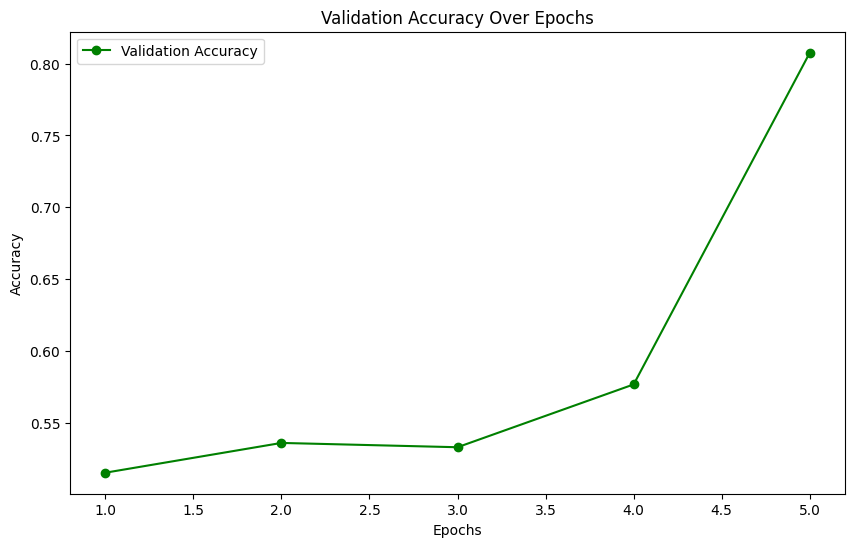

In [80]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy4) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy4, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [82]:
import torch

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for input_batch, output_batch in test_dataloader2:
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        
        outputs = model4(input_batch)
        
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == output_batch).sum().item()  
        total_predictions += output_batch.size(0) 

test_accuracy = correct_predictions / total_predictions  
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.7848


What changes do you observe ?

picking last output - almost gave same accuracy
averging out outputs - gave better accuracy

reasoning : Averaging out outputs across the sequence allows the model to consider information from various time steps, potentially enhancing its understanding of the entire sequence and improving accuracy by mitigating the impact of noisy or irrelevant information.

intuition: if more negative words appear in the review ,there is a chance that review is negative, thus averaging out can capture a better context from every word that way.

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [83]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
epochs = 5
class MeanOutputRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(MeanOutputRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        mean_output = torch.mean(output, dim=1)
        logits = self.fc(mean_output)
        return logits

def train_and_evaluate_model(embedding_dim, hidden_size, batch_size):
    params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2}
    train_dataloader = DataLoader(train_ds2, **params)
    val_dataloader = DataLoader(val_ds2, **params)
    test_dataloader = DataLoader(test_ds2, **params)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = MeanOutputRNNModel(vocab_size2, hidden_size, embedding_dim, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracy = train_model_general(train_dataloader, val_dataloader, model, optimizer)
    
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for input_batch, output_batch in test_dataloader:
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            
            outputs = model(input_batch)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == output_batch).sum().item()
            total_predictions += output_batch.size(0)
    
    test_accuracy = correct_predictions / total_predictions
    print(f'Configuration - Embedding Dim: {embedding_dim}, Hidden Size: {hidden_size}, Batch Size: {batch_size}')
    print(f'Test Accuracy: {test_accuracy:.4f}\n')
    
best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []



train_and_evaluate_model(embedding_dim=128, hidden_size=256, batch_size=32)


Epoch 1/ Validation: 100%|██████████| 126/126 [00:00<00:00, 191.27it/s]


Epoch 1: Train Loss: 0.6844, Val Loss: 0.6855, Val Accuracy: 0.6424


Epoch 2/ Validation: 100%|██████████| 126/126 [00:00<00:00, 208.84it/s]


Epoch 2: Train Loss: 0.6798, Val Loss: 0.6586, Val Accuracy: 0.6537


Epoch 3/ Validation: 100%|██████████| 126/126 [00:00<00:00, 196.79it/s]


Epoch 3: Train Loss: 0.6734, Val Loss: 0.6813, Val Accuracy: 0.7171


Epoch 4/ Validation: 100%|██████████| 126/126 [00:00<00:00, 192.04it/s]


Epoch 4: Train Loss: 0.6685, Val Loss: 0.6568, Val Accuracy: 0.6789


Epoch 5/ Validation: 100%|██████████| 126/126 [00:00<00:00, 205.91it/s]

Epoch 5: Train Loss: 0.6125, Val Loss: 0.5686, Val Accuracy: 0.7814


Configuration - Embedding Dim: 128, Hidden Size: 256, Batch Size: 32
Test Accuracy: 0.7582



In [84]:
train_and_evaluate_model(embedding_dim=256, hidden_size=128, batch_size=64)


Epoch 1/ Validation: 100%|██████████| 63/63 [00:00<00:00, 189.95it/s]


Epoch 1: Train Loss: 0.5811, Val Loss: 0.5102, Val Accuracy: 0.8073


Epoch 2/ Validation: 100%|██████████| 63/63 [00:00<00:00, 187.45it/s]


Epoch 2: Train Loss: 0.3867, Val Loss: 0.3817, Val Accuracy: 0.8381


Epoch 3/ Validation: 100%|██████████| 63/63 [00:00<00:00, 185.79it/s]


Epoch 3: Train Loss: 0.3014, Val Loss: 0.3626, Val Accuracy: 0.8463


Epoch 4/ Validation: 100%|██████████| 63/63 [00:00<00:00, 193.72it/s]


Epoch 4: Train Loss: 0.2255, Val Loss: 0.3687, Val Accuracy: 0.8531


Epoch 5/ Validation: 100%|██████████| 63/63 [00:00<00:00, 200.60it/s]

Epoch 5: Train Loss: 0.1894, Val Loss: 0.3397, Val Accuracy: 0.8588


Configuration - Embedding Dim: 256, Hidden Size: 128, Batch Size: 64
Test Accuracy: 0.8382



In [85]:
train_and_evaluate_model(embedding_dim=64, hidden_size=128, batch_size=16)


Epoch 1/ Validation: 100%|██████████| 251/251 [00:00<00:00, 294.60it/s]


Epoch 1: Train Loss: 0.6066, Val Loss: 0.5148, Val Accuracy: 0.7659


Epoch 2/ Validation: 100%|██████████| 251/251 [00:00<00:00, 334.74it/s]


Epoch 2: Train Loss: 0.4264, Val Loss: 0.4209, Val Accuracy: 0.8161


Epoch 3/ Validation: 100%|██████████| 251/251 [00:00<00:00, 313.92it/s]


Epoch 3: Train Loss: 0.3331, Val Loss: 0.3735, Val Accuracy: 0.8401


Epoch 4/ Validation: 100%|██████████| 251/251 [00:00<00:00, 318.64it/s]


Epoch 4: Train Loss: 0.2519, Val Loss: 0.3926, Val Accuracy: 0.8438


Epoch 5/ Validation: 100%|██████████| 251/251 [00:00<00:00, 294.49it/s]

Epoch 5: Train Loss: 0.1984, Val Loss: 0.3886, Val Accuracy: 0.8483


Configuration - Embedding Dim: 64, Hidden Size: 128, Batch Size: 16
Test Accuracy: 0.8380



In [86]:
train_and_evaluate_model(embedding_dim=256, hidden_size=512, batch_size=128)


Epoch 1/ Validation: 100%|██████████| 32/32 [00:00<00:00, 37.59it/s]


Epoch 1: Train Loss: 0.7046, Val Loss: 0.6641, Val Accuracy: 0.5867


Epoch 2/ Validation: 100%|██████████| 32/32 [00:00<00:00, 38.33it/s]


Epoch 2: Train Loss: 0.6487, Val Loss: 0.5239, Val Accuracy: 0.7519


Epoch 3/ Validation: 100%|██████████| 32/32 [00:00<00:00, 38.31it/s]


Epoch 3: Train Loss: 0.4694, Val Loss: 0.4223, Val Accuracy: 0.8213


Epoch 4/ Validation: 100%|██████████| 32/32 [00:00<00:00, 38.46it/s]


Epoch 4: Train Loss: 0.4729, Val Loss: 0.5785, Val Accuracy: 0.8003


Epoch 5/ Validation: 100%|██████████| 32/32 [00:00<00:00, 38.67it/s]

Epoch 5: Train Loss: 0.5262, Val Loss: 0.6611, Val Accuracy: 0.6917


Configuration - Embedding Dim: 256, Hidden Size: 512, Batch Size: 128
Test Accuracy: 0.6857



In [87]:
train_and_evaluate_model(embedding_dim=512, hidden_size=256, batch_size=64)

Epoch 1/ Validation: 100%|██████████| 63/63 [00:00<00:00, 110.11it/s]


Epoch 1: Train Loss: 0.5735, Val Loss: 0.5263, Val Accuracy: 0.7734


Epoch 2/ Validation: 100%|██████████| 63/63 [00:00<00:00, 112.43it/s]


Epoch 2: Train Loss: 0.3913, Val Loss: 0.3839, Val Accuracy: 0.8343


Epoch 3/ Validation: 100%|██████████| 63/63 [00:00<00:00, 110.65it/s]


Epoch 3: Train Loss: 0.2744, Val Loss: 0.3563, Val Accuracy: 0.8483


Epoch 4/ Validation: 100%|██████████| 63/63 [00:00<00:00, 111.22it/s]


Epoch 4: Train Loss: 0.2012, Val Loss: 0.4099, Val Accuracy: 0.8488


Epoch 5/ Validation: 100%|██████████| 63/63 [00:00<00:00, 111.63it/s]

Epoch 5: Train Loss: 0.1668, Val Loss: 0.3569, Val Accuracy: 0.8566


Configuration - Embedding Dim: 512, Hidden Size: 256, Batch Size: 64
Test Accuracy: 0.8424



as per the observation , a bigger embeddig dimention, with a medium batch size attributed to more accurate results

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [88]:
import torch
import torch.nn as nn

class MeanOutputLSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(MeanOutputLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        
        output, _ = self.lstm(embedded) 
        
        mean_output = torch.mean(output, dim=1)  
        
        logits = self.fc(mean_output)  
        
        return logits
    
model5 = MeanOutputLSTMModel(vocab_size2, hidden_size, embedding_dim, num_classes).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5.to(device)

optimizer5 = torch.optim.Adam(model5.parameters(), lr=learning_rate)

best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []


In [89]:
train_losses5, val_losses5, val_accuracy5 = train_model_general(train_dataloader2,val_dataloader2,model5,optimizer5)

Epoch 1/ Validation: 100%|██████████| 126/126 [00:01<00:00, 82.77it/s]


Epoch 1: Train Loss: 0.5672, Val Loss: 0.4277, Val Accuracy: 0.8188


Epoch 2/ Validation: 100%|██████████| 126/126 [00:01<00:00, 82.75it/s]


Epoch 2: Train Loss: 0.3144, Val Loss: 0.3060, Val Accuracy: 0.8738


Epoch 3/ Validation: 100%|██████████| 126/126 [00:01<00:00, 82.17it/s]


Epoch 3: Train Loss: 0.2011, Val Loss: 0.3045, Val Accuracy: 0.8723


Epoch 4/ Validation: 100%|██████████| 126/126 [00:01<00:00, 83.75it/s]


Epoch 4: Train Loss: 0.1276, Val Loss: 0.3219, Val Accuracy: 0.8761


Epoch 5/ Validation: 100%|██████████| 126/126 [00:01<00:00, 82.89it/s]

Epoch 5: Train Loss: 0.0656, Val Loss: 0.3952, Val Accuracy: 0.8673


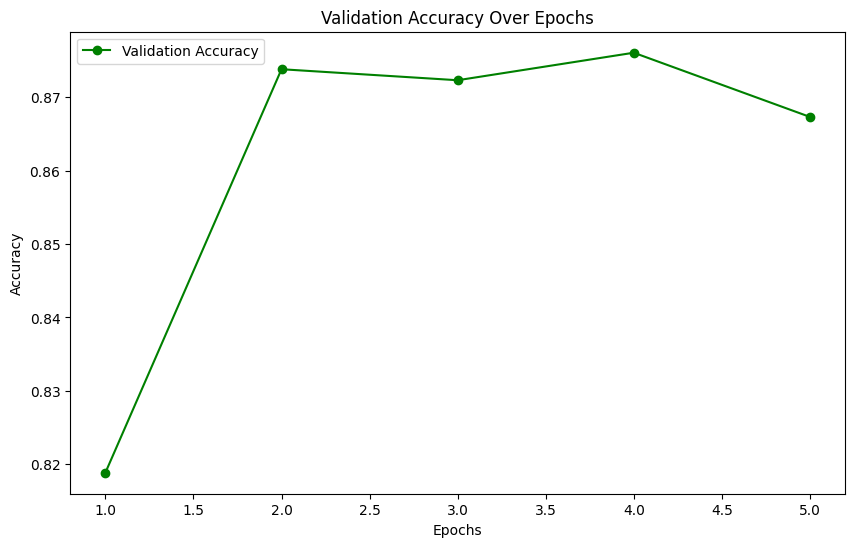

In [90]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy5) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy5, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [91]:
import torch

model5.eval() 
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for input_batch, output_batch in test_dataloader2:
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        
        outputs = model5(input_batch)
        
        _, predicted = torch.max(outputs, 1) 
        correct_predictions += (predicted == output_batch).sum().item()  
        total_predictions += output_batch.size(0)  

test_accuracy = correct_predictions / total_predictions 
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.8600


What changes do you observe ? Explain why LSTM layer would affect performance.


Accuracy increased
because LSTMs capture more context because of the LSTM cell structure, below is the standard explanation


LSTMs (Long Short-Term Memory networks) outperform regular RNNs in sentiment analysis due to their ability to capture long-range dependencies in textual data. Unlike regular RNNs, LSTMs have specialized memory cells that can retain information over longer sequences, allowing them to better understand context and sentiment nuances. This capability helps LSTMs in discerning sentiment from complex sentence structures and varying lengths of text. Furthermore, LSTMs mitigate the vanishing gradient problem encountered in regular RNNs, enabling them to effectively learn from both short and long-range dependencies in text, leading to improved accuracy. Overall, the sophisticated architecture of LSTMs makes them more adept at understanding the subtleties of sentiment expressed in natural language, resulting in enhanced performance in sentiment analysis tasks.